In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import mlflow
import mlflow.sklearn
import dagshub


In [2]:
df = pd.read_csv("clean_emi_data.csv")
df.head()

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
0,38.0,Female,Married,Professional,82600.0,Private,0.9,Mid-size,Rented,20000.0,...,Yes,20000.0,660.0,303200.0,70200.0,Personal Loan EMI,850000.0,15.0,Not_Eligible,500.0
1,38.0,Female,Married,Graduate,21500.0,Private,7.0,MNC,Family,0.0,...,Yes,4100.0,714.0,92500.0,26900.0,E-commerce Shopping EMI,128000.0,19.0,Not_Eligible,700.0
2,38.0,Male,Married,Professional,86100.0,Private,5.8,Startup,Own,0.0,...,No,0.0,650.0,665050.0,267600.0,Education EMI,306000.0,16.0,Eligible,23730.0
3,58.0,Female,Married,High School,66800.0,Private,2.2,Mid-size,Own,0.0,...,No,0.0,685.0,440900.0,178100.0,Vehicle EMI,304000.0,77.5,Eligible,16170.0
4,48.0,Female,Married,Professional,57300.0,Private,3.4,Mid-size,Family,0.0,...,No,0.0,770.0,97300.0,28200.0,Home Appliances EMI,252000.0,7.0,Not_Eligible,500.0


Feature Engineering


In [3]:
df.columns

Index(['age', 'gender', 'marital_status', 'education', 'monthly_salary',
       'employment_type', 'years_of_employment', 'company_type', 'house_type',
       'monthly_rent', 'family_size', 'dependents', 'school_fees',
       'college_fees', 'travel_expenses', 'groceries_utilities',
       'other_monthly_expenses', 'existing_loans', 'current_emi_amount',
       'credit_score', 'bank_balance', 'emergency_fund', 'emi_scenario',
       'requested_amount', 'requested_tenure', 'emi_eligibility',
       'max_monthly_emi'],
      dtype='object')

In [4]:
df.dropna(inplace=True)

In [5]:
df.isna().sum()

age                       0
gender                    0
marital_status            0
education                 0
monthly_salary            0
employment_type           0
years_of_employment       0
company_type              0
house_type                0
monthly_rent              0
family_size               0
dependents                0
school_fees               0
college_fees              0
travel_expenses           0
groceries_utilities       0
other_monthly_expenses    0
existing_loans            0
current_emi_amount        0
credit_score              0
bank_balance              0
emergency_fund            0
emi_scenario              0
requested_amount          0
requested_tenure          0
emi_eligibility           0
max_monthly_emi           0
dtype: int64

Train Test Split

In [6]:
X = df.drop(['max_monthly_emi', 'emi_eligibility'], axis=1)
y = df['max_monthly_emi']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")


Train: (323840, 25), Test: (80960, 25)


Feature Engineeering

In [7]:

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Create new features
        X['debt_to_income'] = X['current_emi_amount'] / (X['monthly_salary'] + 1e-6)
        X['total_monthly_expenses'] = (
            X['monthly_rent'] + X['school_fees'] + X['college_fees'] +
            X['travel_expenses'] + X['groceries_utilities'] + 
            X['other_monthly_expenses'] + X['current_emi_amount']
        )
        X['expense_to_income'] = X['total_monthly_expenses'] / (X['monthly_salary'] + 1e-6)
        X['available_for_new_emi'] = X['monthly_salary'] - X['total_monthly_expenses']
        X['employment_stability_score'] = X['years_of_employment'] / (X['requested_tenure'] + 1e-6)
        X['credit_risk_score'] = 1 - (X['credit_score'] / 850)
        X['emergency_coverage_months'] = X['emergency_fund'] / (X['total_monthly_expenses'] + 1e-6)
        
        return X


In [8]:
X.isna().value_counts()

age    gender  marital_status  education  monthly_salary  employment_type  years_of_employment  company_type  house_type  monthly_rent  family_size  dependents  school_fees  college_fees  travel_expenses  groceries_utilities  other_monthly_expenses  existing_loans  current_emi_amount  credit_score  bank_balance  emergency_fund  emi_scenario  requested_amount  requested_tenure
False  False   False           False      False           False            False                False         False       False         False        False       False        False         False            False                False                   False           False               False         False         False           False         False             False               404800
Name: count, dtype: int64

In [9]:
# Calculate skewness on TRAINING data only
feature_engineer = FeatureEngineer()
X_train_fe = feature_engineer.fit_transform(X_train)

num_columns = X_train_fe.select_dtypes(include=['int64', 'float64']).columns.tolist()
skewness = X_train_fe[num_columns].skew()

low_skew = skewness[abs(skewness) <= 0.5].index.tolist()
moderate_skew = skewness[(abs(skewness) > 0.5) & (abs(skewness) <= 1)].index.tolist()
high_skew = skewness[abs(skewness) > 1].index.tolist()

# Categorical columns
nominal_columns = ['gender', 'marital_status', 'employment_type', 'company_type', 'house_type', 'emi_scenario']
ordinal_columns = ['education']
binary_columns = ['existing_loans']

education_order = ['High School', 'Graduate', 'Professional', 'Post Graduate']

print(f"\nLow skew: {len(low_skew)} features")
print(f"Moderate skew: {len(moderate_skew)} features")
print(f"High skew: {len(high_skew)} features")


Low skew: 4 features
Moderate skew: 11 features
High skew: 9 features


In [10]:
def safe_log_transform(X):
    return np.log1p(np.clip(X, a_min=0, a_max=None))

Preprocessing Pipeline

In [11]:


# Numeric pipelines
numeric_low = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

numeric_mod = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(safe_log_transform, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

numeric_high = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(safe_log_transform, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

# Categorical pipelines
categorical_nominal = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

categorical_ordinal = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[education_order]))
])

categorical_binary = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[['No', 'Yes']], handle_unknown='use_encoded_value', unknown_value=-1))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('low_skew', numeric_low, low_skew),
        ('mod_skew', numeric_mod, moderate_skew),
        ('high_skew', numeric_high, high_skew),
        ('nominal', categorical_nominal, nominal_columns),
        ('ordinal', categorical_ordinal, ordinal_columns),
        ('binary', categorical_binary, binary_columns)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)


Feature Selection

In [12]:
feature_selector = SelectFromModel(RandomForestRegressor(n_estimators = 100,random_state=42),threshold="median")

In [ ]:

results = {}

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBoost Regressor": XGBRegressor()
}

# Loop through models
for name, model in models.items():
    pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('feature_selector',feature_selector),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

     # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,RMSE,R2 Score
Linear Regression,2391.720064,1.081073e+07,3287.967183,0.753694
Decision Tree Regressor,568.212349,2.449756e+06,1565.169509,0.944186
Random Forest Regressor,435.169607,1.238878e+06,1113.049132,0.971774
XGBoost Regressor,464.472259,9.383664e+05,968.693116,0.978621


Mlflow Integration


In [13]:
import dagshub
dagshub.init(repo_owner='SachinMosambe', repo_name='AI-Intelligent-Financial-Risk-Assessment-Platform', mlflow=True)

Accessing as SachinMosambe

Initialized MLflow to track repo "SachinMosambe/AI-Intelligent-Financial-Risk-Assessment-Platform"

Repository SachinMosambe/AI-Intelligent-Financial-Risk-Assessment-Platform initialized!

In [14]:
mlflow.set_tracking_uri("https://dagshub.com/SachinMosambe/AI-Intelligent-Financial-Risk-Assessment-Platform.mlflow")
mlflow.set_experiment("Regression_Models")

<Experiment: artifact_location='mlflow-artifacts:/fa9826e8c9c64cb2b809ded48b24b2fb', creation_time=1760345775560, experiment_id='2', last_update_time=1760345775560, lifecycle_stage='active', name='Regression_Models', tags={}>

Train and logging

logging cross validation

In [22]:
models = {
    "Linear Regression": LinearRegression(n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_jobs=-1),
    "XGBoost": XGBRegressor(tree_method="gpu_hist", random_state=42)
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv_results = {}

In [ ]:
for name, model in models.items():
    with mlflow.start_run(run_name=f"{name}_CV"):
        pipeline = Pipeline([
            ('feature_engineering', FeatureEngineer()),
            ('preprocessor', preprocessor),
            ('feature_selector', feature_selector),
            ('regressor', model)
        ])

        # Cross-validation metrics
        mae_scores = -cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
        mse_scores = -cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        r2_scores  = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
        rmse_scores = np.sqrt(mse_scores)
        nrmse_scores = rmse_scores / (y_train.max() - y_train.min())

        # Compute means
        mean_mae = mae_scores.mean()
        mean_mse = mse_scores.mean()
        mean_rmse = rmse_scores.mean()
        mean_nrmse = nrmse_scores.mean()
        mean_r2 = r2_scores.mean()

        # Log parameters + metrics
        mlflow.log_param("Model", name)
        if hasattr(model, "get_params"):
            mlflow.log_params(model.get_params())

        mlflow.log_metrics({
            "CV_MAE": mean_mae,
            "CV_MSE": mean_mse,
            "CV_RMSE": mean_rmse,
            "CV_NRMSE": mean_nrmse,
            "CV_R2": mean_r2
        })

        # Store results
        cv_results[name] = {
            "MAE": mean_mae,
            "MSE": mean_mse,
            "RMSE": mean_rmse,
            "NRMSE": mean_nrmse,
            "R2": mean_r2
        }

        print(f"{name}: R2={mean_r2:.4f}, MAE={mean_mae:.4f}, RMSE={mean_rmse:.4f}")

# Compare models
results_df = pd.DataFrame(cv_results).T
best_model_name = results_df["R2"].idxmax()
best_model = models[best_model_name]
print(f"\n Best model from CV: {best_model_name}")
print(results_df)

Linear Regression: R2=0.7595, MAE=2389.9257, RMSE=3263.3709
🏃 View run Linear Regression_CV at: https://dagshub.com/SachinMosambe/AI-Intelligent-Financial-Risk-Assessment-Platform.mlflow/#/experiments/2/runs/d2acdf6479654cfea8311e331cb38662
🧪 View experiment at: https://dagshub.com/SachinMosambe/AI-Intelligent-Financial-Risk-Assessment-Platform.mlflow/#/experiments/2
Decision Tree: R2=0.9421, MAE=594.1071, RMSE=1606.8873
🏃 View run Decision Tree_CV at: https://dagshub.com/SachinMosambe/AI-Intelligent-Financial-Risk-Assessment-Platform.mlflow/#/experiments/2/runs/a853ed3131ce435a87af245478856fd5
🧪 View experiment at: https://dagshub.com/SachinMosambe/AI-Intelligent-Financial-Risk-Assessment-Platform.mlflow/#/experiments/2
Random Forest: R2=0.9705, MAE=453.2851, RMSE=1145.3935
🏃 View run Random Forest_CV at: https://dagshub.com/SachinMosambe/AI-Intelligent-Financial-Risk-Assessment-Platform.mlflow/#/experiments/2/runs/4350626f17e947269858279c66a3fdcc
🧪 View experiment at: https://dagshub

In [15]:
best_model_name = 'XGBoost'

In [16]:
models = {
    "Linear Regression": LinearRegression(n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_jobs=-1),
    "XGBoost": XGBRegressor(tree_method="gpu_hist", random_state=42)
}

best_model = models[best_model_name]
print(f"✅ Using best model: {best_model_name}")

✅ Using best model: XGBoost


In [17]:
# Define hyperparameter grid for the best model
param_grids = {
    "Random Forest": {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [5, 10, 15, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4],
        'regressor__max_features': ['sqrt', 'log2', None],
        'regressor__bootstrap': [True, False]
    },
    "XGBoost": {
        "regressor__n_estimators": [200, 300, 500],
        "regressor__max_depth": [4, 6, 8],
        "regressor__learning_rate": [0.01, 0.05, 0.1],
        "regressor__min_child_weight": [1, 2],
        "regressor__gamma": [0, 0.1],
    },
    "Linear Regression": {},
    "Decision Tree": {
        'regressor__max_depth': [None, 5, 10, 15],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
}

param_grid = param_grids.get(best_model_name, {})

logging hyperparamter tunning

In [18]:
# Hyperparameter tuning only for best model
pipeline = Pipeline([
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('regressor', best_model)
])

with mlflow.start_run(run_name=f"{best_model_name}_Hyperparameter_Tuning"):

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid if param_grid else {},
        n_iter=10,
        cv=3,
        verbose=1,
        n_jobs=-1,
        scoring='r2',
        random_state=42
    )

    search.fit(X_train, y_train)

    best_estimator = search.best_estimator_ if param_grid else pipeline
    best_params = search.best_params_ if param_grid else {}
    best_cv_r2 = search.best_score_ if param_grid else results_df.loc[best_model_name, "R2"]

    # Log hyperparameters and CV metric
    mlflow.log_params(best_params)
    mlflow.log_metric("Best_CV_R2", best_cv_r2)

    # Evaluate on test set
    y_pred = best_estimator.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)


    mlflow.log_metrics({
        "Test_MAE": mae,
        "Test_MSE": mse,
        "Test_RMSE": rmse,
        "Test_R2": r2
    })

    # Save pipeline and register model
    model_filename = f"best_{best_model_name.replace(' ', '_')}_pipeline.pkl"
    joblib.dump(best_estimator, model_filename)
    mlflow.log_artifact(model_filename, artifact_path="models")




Fitting 3 folds for each of 10 candidates, totalling 30 fits
🏃 View run XGBoost_Hyperparameter_Tuning at: https://dagshub.com/SachinMosambe/AI-Intelligent-Financial-Risk-Assessment-Platform.mlflow/#/experiments/2/runs/b49a611e1b484763a7279ffde55cb964
🧪 View experiment at: https://dagshub.com/SachinMosambe/AI-Intelligent-Financial-Risk-Assessment-Platform.mlflow/#/experiments/2


Regression Visualizations

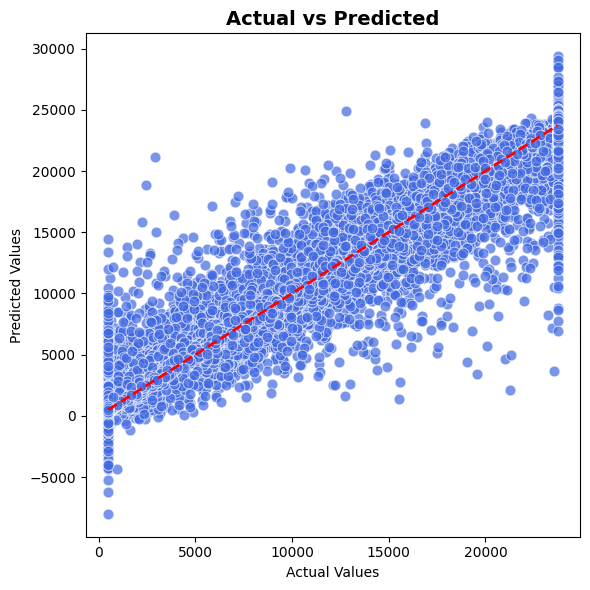

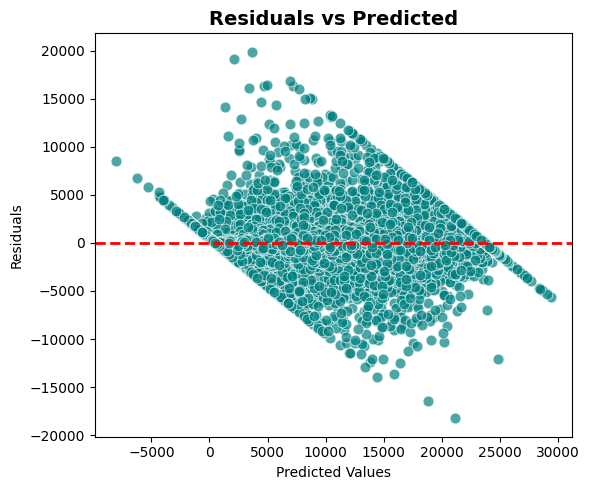

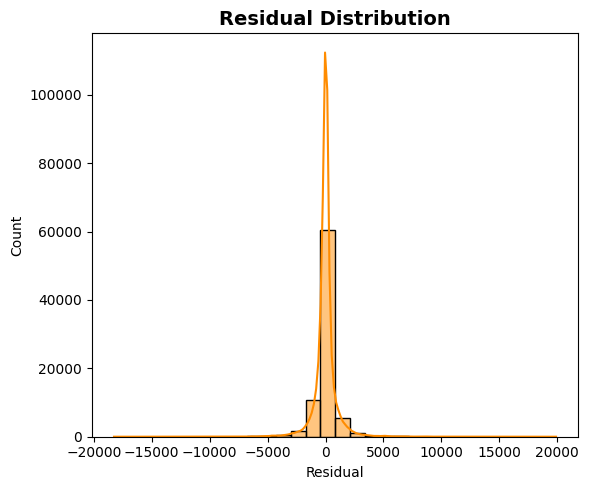

In [19]:

import matplotlib.pyplot as plt
import seaborn as sns

# Predicted vs Actual Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.7, s=60, edgecolor='white')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted', fontsize=14, fontweight='bold')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
plt.savefig("actual_vs_predicted.png", dpi=300)
mlflow.log_artifact("actual_vs_predicted.png")
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_pred, y=residuals, color='teal', alpha=0.7, s=60, edgecolor='white')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.title('Residuals vs Predicted', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.tight_layout()
plt.savefig("residuals_vs_predicted.png", dpi=300)
mlflow.log_artifact("residuals_vs_predicted.png")
plt.show()

# Residual Distribution
plt.figure(figsize=(6, 5))
sns.histplot(residuals, kde=True, color='darkorange', bins=30)
plt.title('Residual Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Residual')
plt.tight_layout()
plt.savefig("residual_distribution.png", dpi=300)
mlflow.log_artifact("residual_distribution.png")
plt.show()

# Log residual stats
mlflow.log_metrics({
    "Residual_Mean": np.mean(residuals),
    "Residual_Std": np.std(residuals)
})
